In [75]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import cv2 
from numpy import asarray
from PIL import Image, ImageFilter


warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
os.chdir('/content/drive/MyDrive/all_images/all image')
if os.path.isdir('train/normal') is False:
    os.makedirs('train/normal')
    os.makedirs('train/Malignant')
    os.makedirs('valid/normal')
    os.makedirs('valid/Malignant')
    os.makedirs('test/normal')
    os.makedirs('test/Malignant')

    for i in random.sample(glob.glob('Malignant case*'), 448):
        shutil.move(i, 'train/Malignant')      
    for i in random.sample(glob.glob('Normal case*'), 332):
        shutil.move(i, 'train/normal')
    for i in random.sample(glob.glob('Malignant case*'), 56):
        shutil.move(i, 'valid/Malignant')        
    for i in random.sample(glob.glob('Normal case*'), 41):
        shutil.move(i, 'valid/normal')
    for i in random.sample(glob.glob('Malignant case*'), 56):
        shutil.move(i, 'test/Malignant')      
    for i in random.sample(glob.glob('Normal case*'), 41):
        shutil.move(i, 'test/normal')


In [78]:
train_path = '/content/drive/MyDrive/all_images/all image/train'
valid_path = '/content/drive/MyDrive/all_images/all image/valid'
test_path = '/content/drive/MyDrive/all_images/all image/test'

In [79]:
train_batches = ImageDataGenerator() \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['Malignant', 'normal'], batch_size=10)
valid_batches = ImageDataGenerator() \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Malignant', 'normal'], batch_size=10)
test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Malignant', 'normal'], batch_size=10, shuffle=False)

Found 780 images belonging to 2 classes.
Found 97 images belonging to 2 classes.
Found 97 images belonging to 2 classes.


In [80]:
def preprocessingfunction(train_batches):

    imgs, labels = next(train_batches)
    imgs=imgs.astype(np.uint8)
    data = [] 

    for i in range(10): 
        img=imgs[i]
        #print(i)
        img = cv2.resize(img, (512, 512))
        #remove noise
        img = cv2.GaussianBlur(img,(5,5),0)
   
    
        array = asarray(img)
        #see edges 
        img=Image.fromarray((array))
        final= img.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,-1, -1, -1, -1), 1, 0))
        img=final+array  
        img=Image.fromarray((img))
        #img = img.filter(ImageFilter.FIND_EDGES)
        # Convert the image to grayscale
        img = img.convert("L")
        img = asarray(img)
        #segmnation
        ret, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
        #d, img = hog(img, orientations=9 ,pixels_per_cell=(4, 4)
        #                ,cells_per_block=(2, 2), visualize=True)# multichannel=True
        #img = exposure.rescale_intensity(img, in_range=(0, 10)) 
 
        #append in=mage in data
        data.append(img)
    train_batches=data, labels
    print(train_batches)

In [81]:
preprocessingfunction(train_batches)

([array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 

In [82]:
def preprocessingfunction_v(valid_batches):

    imgs, labels = next(valid_batches)
    imgs=imgs.astype(np.uint8)
    data = [] 

    for i in range(10): 
        img=imgs[i]
        #print(i)
        img = cv2.resize(img, (512, 512))
        #remove noise
        img = cv2.GaussianBlur(img,(5,5),0)
   
    
        array = asarray(img)
        #see edges 
        img=Image.fromarray((array))
        final= img.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,-1, -1, -1, -1), 1, 0))
        img=final+array  
        img=Image.fromarray((img))
        #img = img.filter(ImageFilter.FIND_EDGES)
        # Convert the image to grayscale
        img = img.convert("L")
        img = asarray(img)
        #segmnation
        ret, img = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
        #d, img = hog(img, orientations=9 ,pixels_per_cell=(4, 4)
        #                ,cells_per_block=(2, 2), visualize=True)# multichannel=True
        #img = exposure.rescale_intensity(img, in_range=(0, 10)) 
 
        #append in=mage in data
        data.append(img)
        #عشان متكومش label بتتعاد
    valid_batches=imgs, labels
    print(valid_batches)

In [83]:
preprocessingfunction_v(valid_batches)

(array([[[[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]],

        [[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]],

        [[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]],

        ...,

        [[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]],

        [[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]],

        [[38, 38, 38],
         [38, 38, 38],
         [38, 38, 38],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [38, 38, 38]]],


       [[[38, 38, 38],
         [38, 38, 38],
         [38,

In [84]:
print(train_batches)

In [85]:
imgs, labels = next(train_batches)

In [86]:
imgs=imgs.astype(np.uint8)

In [87]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [88]:
arr=preprocessingfunction(train_batches)
print(arr)

([array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 

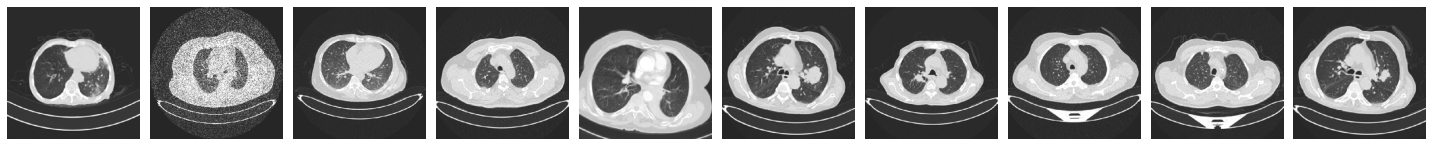

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [89]:
plotImages(imgs)
print(labels)

In [90]:
#plt.imshow(data[8])

In [91]:
#plt.imshow(arr[1])

In [92]:
#model = Sequential([
#    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(512,512,3)),
#    MaxPool2D(pool_size=(2, 2), strides=2),
#    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
#    MaxPool2D(pool_size=(2, 2), strides=2),
#    Flatten(),
#    Dense(units=2, activation='softmax')
#])

In [93]:
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [94]:
#model.fit(x=train_batches,
#    steps_per_epoch=len(train_batches),
#    validation_data=valid_batches,
#    validation_steps=len(valid_batches),
#    epochs=2,
#    verbose=2
#)

In [95]:
resnet50 = keras.applications.resnet50


In [96]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [97]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
#history = full_model.fit_generator(
#    train_batches, 
#    validation_data = valid_batches,
#    workers=10,
#    epochs=5,
#)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [98]:
full_model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
   verbose=2
)

Epoch 1/10
78/78 - 131s - loss: 0.2797 - acc: 0.9718 - val_loss: 0.0269 - val_acc: 1.0000 - 131s/epoch - 2s/step
Epoch 2/10
78/78 - 126s - loss: 0.0274 - acc: 0.9936 - val_loss: 0.0554 - val_acc: 0.9897 - 126s/epoch - 2s/step
Epoch 3/10
78/78 - 132s - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0318 - val_acc: 0.9897 - 132s/epoch - 2s/step
Epoch 4/10
78/78 - 127s - loss: 2.7331e-04 - acc: 1.0000 - val_loss: 3.2930e-04 - val_acc: 1.0000 - 127s/epoch - 2s/step
Epoch 5/10
78/78 - 126s - loss: 2.2649e-05 - acc: 1.0000 - val_loss: 4.3734e-04 - val_acc: 1.0000 - 126s/epoch - 2s/step
Epoch 6/10
78/78 - 126s - loss: 1.6892e-05 - acc: 1.0000 - val_loss: 5.1145e-04 - val_acc: 1.0000 - 126s/epoch - 2s/step
Epoch 7/10
78/78 - 126s - loss: 1.4048e-05 - acc: 1.0000 - val_loss: 5.6381e-04 - val_acc: 1.0000 - 126s/epoch - 2s/step
Epoch 8/10
78/78 - 126s - loss: 1.2360e-05 - acc: 1.0000 - val_loss: 6.1877e-04 - val_acc: 1.0000 - 126s/epoch - 2s/step
Epoch 9/10
78/78 - 125s - loss: 1.1049e-05 - acc: 1.0000

In [99]:
predictions = full_model.predict(x=test_batches, steps=len(test_batches), verbose=0)


In [100]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [101]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm

array([[56,  0],
       [ 2, 39]])

# New Section